In [1]:
'''This script demonstrates how to build a variational autoencoder with Keras.

 KL-Divergence
 
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

from scipy.optimize import fmin
from scipy.stats import entropy
from scipy.stats import norm
import sys


# show the network
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


------------ Sanity check start -------------
Numeric values should be somehow equal to the analytic values!
KLD left vs. middle (numeric): 4.499999999998725
KLD right vs. middle (numeric): 4.499999999998716
KLD left vs. middle (analytic): 4.5
KLD right vs. middle (analytic): 4.5
------------ Sanity check end -------------

A DK-minimization approach that samples either N_1 or N_2 will try to put theresulting N into the middle of both distributions, because it does not see any relationbetween these distributionsThis is because the KL defined on single Gaussian does only cover one Gaussian at a time,Therefore, it is obvious that the minimum resulting N has mu=0.5(mu_1 + mu_2) and std = sqrt(std_1^2 + std_2^2)

mu_mid, mu_left, mu_right, std_mid, std_left, std_right: 0.0, -3.0, 3.0, 0.5, 1.0, 1.0
1. KLD joint vs. middle (sum of single KLD, i.e. optimized by the NN): 9.63629436111989
2. KLD joint vs. middle (numeric and corrent KLD between joint and middle PDF): 4.117216317960012


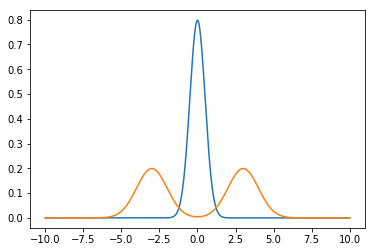


mu_mid, mu_left, mu_right, std_mid, std_left, std_right: 0.0, -3.0, 3.0, 1.0, 1.0, 1.0
1. KLD joint vs. middle (sum of single KLD, i.e. optimized by the NN): 9.0
2. KLD joint vs. middle (numeric and corrent KLD between joint and middle PDF): 2.69335197659556


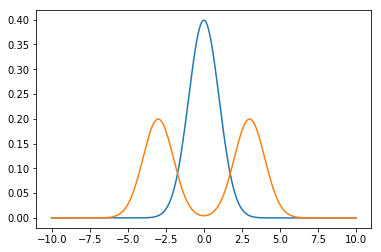


mu_mid, mu_left, mu_right, std_mid, std_left, std_right: 0.0, -3.0, 3.0, 2.0, 1.0, 1.0
1. KLD joint vs. middle (sum of single KLD, i.e. optimized by the NN): 10.61370563888011
2. KLD joint vs. middle (numeric and corrent KLD between joint and middle PDF): 1.1584279456567113


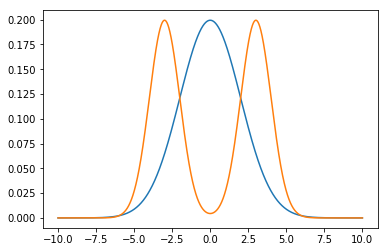


mu_mid, mu_left, mu_right, std_mid, std_left, std_right: 0.0, -3.0, 3.0, 3.0, 1.0, 1.0
1. KLD joint vs. middle (sum of single KLD, i.e. optimized by the NN): 14.80277542266378
2. KLD joint vs. middle (numeric and corrent KLD between joint and middle PDF): 0.8585267149598277


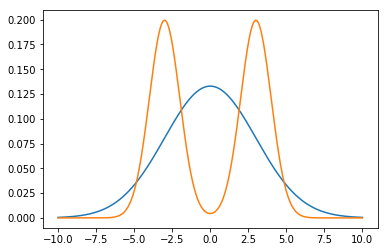


mu_mid, mu_left, mu_right, std_mid, std_left, std_right: 0.0, -3.0, 3.0, 4.0, 1.0, 1.0
1. KLD joint vs. middle (sum of single KLD, i.e. optimized by the NN): 21.22741127776022
2. KLD joint vs. middle (numeric and corrent KLD between joint and middle PDF): 1.357089815987385


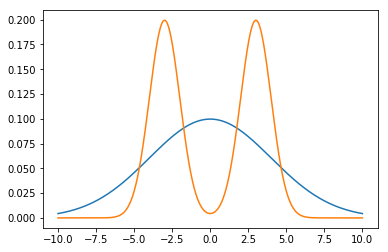


It can be seen, that both error functions (not metrics) are convex butat different points of the standard deviation. The KLD of the full joint dstiribution tries tends to have a minima where the overlapping is the highest whilst the disjunct approach only matches the variance quantity and average mean.


In [2]:
def dkl_gauss(mu1, std1, mu2, std2):
    # DKL(N(mu1, std1)||N(mu2, std2)) 
    return np.log(std2) - np.log(std1) + std1**2 / (2 * std2**2) + (mu1 - mu2)**2 / (2 * std2**2) - 1/2

def dkl_gauss_opt(mu_std, mu1, std1):
    # returns DKL(N(mu_std)||N(mu1, std1))
    return dkl_gauss(mu_std[0], mu_std[1], mu1, std1)

def dkl_gauss_opt2(mu_std, mu1, std1, mu2, std2):
    # returns the sum DKL(N(mu_std)||N(mu1, std1)) + DKL(N(mu_std)||N(mu2, std2))
    return dkl_gauss(mu_std[0], mu_std[1], mu1, std1) + dkl_gauss(mu_std[0], mu_std[1], mu2, std2)

def norm_multi(x, pdf):
    # returns normalized PDF of all scipy continues random variable (rv_continuous) PDF functions in the list pdf
    r = np.zeros(pdf[0].shape())
    for f in pdf:
        r += f.pdf(x)
    return r / np.float(len(pdf))

def entropy_sanity(pk, qk):
    # Calculate KL divergence between the ground-truth pk and approximator qk
    # remove zero values because it causes divide by zero errors: https://datascience.stackexchange.com/questions/11320/kl-divergence-returns-infinity
    pk[pk <= sys.float_info.min] = sys.float_info.min
    qk[qk <= sys.float_info.min] = sys.float_info.min
    return entropy(pk = pk, qk = qk)


def entropy_opt(mu_std, qk, x):
    # returns DKL(N(mu_std)||qk)
    rv = norm(loc = mu_std[0], scale = mu_std[1])
    return entropy_sanity(pk = rv.pdf(x), qk = qk)


# def entropy_opt2(mu_std, mu1 = mu1, std1 = std1, mu2 = mu2, std2 = std2):

#initialize a normal distribution with frozen in mean=-1, std. dev.= 1
rv = norm(loc = 0., scale = 1.0)
rv1 = norm(loc = -3., scale = 1.0)
rv2 = norm(loc = 3., scale = 1.0)
x = np.arange(-10, 10, .001)

# plot the pdfs of these normal distributions 
#plt.plot(x, rv.pdf(x), x, norm_multi(x, [rv1, rv2]))
#plt.show()

print("------------ Sanity check start -------------")
print("Calculate KL divergence between uni-modal distributions.")
print("Numeric values should be somehow equal to the analytic values!")
# numeric
dkl_num_LvsM = entropy_sanity(pk = rv.pdf(x), qk = rv1.pdf(x))
dkl_num_RvsM = entropy_sanity(pk = rv.pdf(x), qk = rv2.pdf(x))
print("KLD left vs. middle (numeric): " + str(dkl_num_LvsM))
print("KLD right vs. middle (numeric): " + str(dkl_num_RvsM))
# analytic
print("KLD left vs. middle (analytic): " + str(dkl_gauss_opt([rv.mean(), rv.std()], mu1 = rv1.mean(), std1 = rv1.std())))
print("KLD right vs. middle (analytic): " + str(dkl_gauss_opt([rv.mean(), rv.std()], mu1 = rv1.mean(), std1 = rv2.std())))
print("------------ Sanity check end -------------")
print("")

print("A DK-minimization approach that samples either N_1 or N_2 will try to put the" +
    "resulting N into the middle of both distributions, because it does not see any relation" +
    "between these distributions" +
    "This is because the KL defined on single Gaussian does only cover one Gaussian at a time," +
    "Therefore, it is obvious that the minimum resulting N has mu=0.5(mu_1 + mu_2) and std = sqrt(std_1^2 + std_2^2)")
print("")

def KLD_eval(rv, rv1, rv2):
    print("mu_mid, mu_left, mu_right, std_mid, std_left, std_right: "
          + str(rv.mean()) + ", " + str(rv1.mean()) + ", " + str(rv2.mean()) + ", "
          + str(rv.std()) + ", " + str(rv1.std()) + ", " + str(rv2.std()))
    print("1. KLD joint vs. middle (sum of single KLD, i.e. optimized by the NN): " + str(dkl_gauss_opt2([rv.mean(), rv.std()], mu1 = rv1.mean(), std1 = rv1.std(),mu2 = rv2.mean(), std2 = rv2.std())))
    print("2. KLD joint vs. middle (numeric and corrent KLD between joint and middle PDF): " + str(entropy_sanity(pk = rv.pdf(x), qk = norm_multi(x, [rv1, rv2]))))
    #plot the pdfs of these normal distributions 
    plt.plot(x, rv.pdf(x), x, norm_multi(x, [rv1, rv2]))
    plt.show()
    print("")

rv = norm(loc = 0., scale = .5)
KLD_eval(rv, rv1, rv2)
rv = norm(loc = 0., scale = 1.0)
KLD_eval(rv, rv1, rv2)
rv = norm(loc = 0., scale = 2.0)
KLD_eval(rv, rv1, rv2)
rv = norm(loc = 0., scale = 3.0)
KLD_eval(rv, rv1, rv2)
rv = norm(loc = 0., scale = 4.0)
KLD_eval(rv, rv1, rv2)

print("It can be seen, that both error functions (not metrics) are convex but" + 
      " at different points of the standard deviation. The KLD of the full joint" + 
      " dstiribution tries tends to have a minima where the overlapping is the highest" + 
      " whilst the disjunct approach only matches the variance quantity and average mean.")


In [3]:
# Sanity Check: Single Gaussian optimization

# Inital seed
mu_init = 1
std_init = 1.2
x0 = [mu_init, std_init]
# Target parameters
mu1 = 0.
std1 = 1.

xOpt = fmin(dkl_gauss_opt, x0, args=(mu1, std1,))
print("Befor Optimization: " + str(dkl_gauss_opt(x0, mu1 = mu1, std1 = std1)))
print("After Optimization: " + str(dkl_gauss_opt(xOpt, mu1 = mu1, std1 = std1)))
print("mu: " + str(round(xOpt[0],2)) + ", std: " + str(round(xOpt[1],2)))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 37
         Function evaluations: 73
Befor Optimization: 0.5376784432060453
After Optimization: 5.775406819452655e-10
mu: -0.0, std: 1.0


In [4]:
# Multi Gaussian optimization (as it would be done by NN)

# Inital seed
mu_init = 1
var_init = 1.2
x0 = [mu_init, var_init]
# Target parameters
mu1 = 1.
std1 = 1.
mu2 = -1.
std2 = 1.

#mu1 = 10.
#std1 = 1.
#mu2 = -10.
#std2 = 2.


xOpt = fmin(dkl_gauss_opt2, x0, args=(mu1, std1, mu2, std2,))
print("Befor Optimization: " + str(dkl_gauss_opt2(x0, mu1 = mu1, std1 = std1, mu2 = mu2, std2 = std2)))
print("After Optimization: " + str(dkl_gauss_opt2(xOpt, mu1 = mu1, std1 = std1, mu2 = mu2, std2 = std2)))
print("mu: " + str(round(xOpt[0],2)) + ", std: " + str(round(xOpt[1],2)))

Optimization terminated successfully.
         Current function value: 40.223144
         Iterations: 50
         Function evaluations: 95
Befor Optimization: 55.853504066972036
After Optimization: 40.223143552303455
mu: 6.0, std: 1.26


In [5]:
# Mixture of Gaussian optimization

# Inital seed
mu_init = 1
var_init = 1.2
x0 = [mu_init, var_init]
# Target parameters
mu1 = 1.
var1 = 1.
mu2 = -1.
var2 = 1.

pdf_joint = norm_multi(x, [norm(loc = mu1, scale = std1), norm(loc = mu2, scale = std2)])
x = np.arange(-10, 10, .001)
xOpt = fmin(entropy_opt, x0, args=(pdf_joint, x,))

# Print
rv = norm(loc = x0[0], scale = x0[1])
print("Befor Optimization: " + str(entropy_sanity(pk = rv.pdf(x), qk = pdf_joint)))
rv = norm(loc = xOpt[0], scale = xOpt[1])
print("After Optimization: " + str(entropy_sanity(pk = rv.pdf(x), qk = pdf_joint)))
print("mu: " + str(round(xOpt[0],2)) + ", std: " + str(round(xOpt[1],2)))


Optimization terminated successfully.
         Current function value: 0.056211
         Iterations: 38
         Function evaluations: 73
Befor Optimization: 0.21337213167744198
After Optimization: 0.05621097962918525
mu: 0.03, std: 1.75


In [6]:
batch_size = 100
input_dim_dummy = 1 # const.
latent_dim_1 = 16
latent_dim_2 = 16
latent_dim_samp = 1
epochs = 50

def get_model():
    mean_target = Input(shape=(latent_dim_samp,), name="input_mean_target")
    std_target = Input(shape=(latent_dim_samp,), name="input_std_target")
    x = Input(shape=(input_dim_dummy,), name="input_dummy")
    h1 = Dense(latent_dim_1, activation='relu', name="latent1")(x)
    h2 = Dense(latent_dim_2, activation='relu', name="latent2")(h1)
    mean = Dense(latent_dim_samp, name="mean")(h2)
    std = Dense(latent_dim_samp, name="std")(h2)
    
    
    def sampling(args):
        mu, std = args
        epsilon = K.random_normal(shape=(K.shape(mean)[0], latent_dim_samp), mean=0., stddev=1.)
        return mean + std * epsilon
    
    # note that "output_shape" isn't necessary with the TensorFlow backend
    sample        = Lambda(sampling, output_shape=(latent_dim_samp,), name="sample")([mean, std])
    sample_target = Lambda(sampling, output_shape=(latent_dim_samp,), name="sample_target")([mean_target, std_target])
    return sample, sample_target, mean_target, std_target, mean, std, x

# Custom loss layer with KL and MSE loss
class CustomVariationalReconstructLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalReconstructLayer, self).__init__(**kwargs)
        
    def kl_loss(self, mean_target, std_target, mean, std):
        return K.sum(K.log(std_target) - K.log(std) + 
                     (K.square(std) + K.square(mean - mean_target)) / (2*K.square(std_target)) -
                     1/2. , axis=-1)

    def loss(self, sample, sample_target, mean_target, std_target, mean, std):
        mse_loss = latent_dim_samp * metrics.mean_squared_error(sample, sample_target)
        #mse_loss = 1 / (1+ K.abs(sample))
        return K.mean(mse_loss + self.kl_loss(mean_target, std_target, mean, std))

    def call(self, inputs):
        sample = inputs[0]
        sample_target = inputs[1]
        mean_target = inputs[2]
        std_target = inputs[3]
        mean = inputs[4]
        std = inputs[5]
        loss = self.loss(sample, sample_target, mean_target, std_target, mean, std)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return sample

# Custom loss layer with KL loss only
class CustomVariationalLayer(CustomVariationalReconstructLayer):
    def __init__(self, **kwargs):
        super(CustomVariationalLayer, self).__init__(**kwargs)
        
    def loss(self, sample, sample_target, mean_target, std_target, mean, std):
        return K.mean(self.kl_loss(mean_target, std_target, mean, std))


In [7]:
# Define training data
num = 5000
mean_target_noise_std = 0.01
mean_targets_gt = np.array([-1., 1.])

std_target_noise_std = 0.1
std_targets_gt = np.array([1., 1.])

target_choice = np.random.choice(np.int32([0, 1]), size=(num,))
mean_targets_samples = mean_targets_gt[target_choice] + mean_target_noise_std * np.random.standard_normal(size=(num,))
std_target_samples = std_targets_gt[target_choice] + std_target_noise_std * (np.random.rand(num) - 0.5)
dummy = np.random.rand(num)
# dummy = np.ones((num,))



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


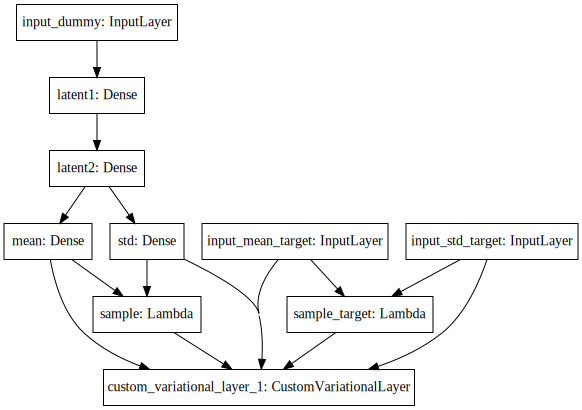

In [8]:
sample, sample_target, mean_target, std_target, mean, std, x = get_model()
y_kl = CustomVariationalLayer()([sample, sample_target, mean_target, std_target, mean, std])
model_kl = Model([mean_target, std_target, x], y_kl)
model_kl.compile(optimizer='adam', loss=None)

SVG(model_to_dot(model_kl).create(prog='dot', format='svg'))



In [9]:
# train the model
model_kl.fit(x = [mean_targets_samples, std_target_samples, dummy],
            y = None,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size)

Epoch 1/50
5000/5000 [==============================] - 2s 304us/step - loss: 33.0100
Epoch 2/50
5000/5000 [==============================] - 0s 35us/step - loss: 31.4798
Epoch 3/50
5000/5000 [==============================] - 0s 30us/step - loss: 29.4404
Epoch 4/50
5000/5000 [==============================] - 0s 28us/step - loss: 26.9828
Epoch 5/50
5000/5000 [==============================] - 0s 27us/step - loss: 24.4213
Epoch 6/50
5000/5000 [==============================] - 0s 27us/step - loss: 22.2435
Epoch 7/50
5000/5000 [==============================] - 0s 28us/step - loss: 20.8769
Epoch 8/50
5000/5000 [==============================] - 0s 25us/step - loss: 20.5267
Epoch 9/50
5000/5000 [==============================] - 0s 21us/step - loss: 20.4619
Epoch 10/50
5000/5000 [==============================] - 0s 23us/step - loss: 20.4127
Epoch 11/50
5000/5000 [==============================] - 0s 24us/step - loss: 20.3641
Epoch 12/50
5000/5000 [==============================] - 0s 23

In [10]:
estimation_kl = Model(x, [mean, std])
mean_estimated_kl, std_estimated_kl = estimation_kl.predict(np.array([0.5]))[0], estimation_kl.predict(np.array([0.5]))[1]
print("mean_estimated: " + str(mean_estimated_kl))
print("std_estimated: " + str(std_estimated_kl))
# SVG(model_to_dot(estimation).create(prog='dot', format='svg'))

mean_estimated: [[6.246223]]
std_estimated: [[1.2504721]]


In [11]:
sample, sample_target, mean_target, std_target, mean, std, x = get_model()
y_kle = CustomVariationalReconstructLayer()([sample, sample_target, mean_target, std_target, mean, std])
model_kle = Model([mean_target, std_target, x], y_kle)
model_kle.compile(optimizer='adam', loss=None)

# train the model
model_kle.fit(x = [mean_targets_samples, std_target_samples, dummy],
            y = None,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: Output "custom_variational_reconstruct_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_reconstruct_layer_1" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
5000/5000 [==============================] - 0s 67us/step - loss: 20.0298
Epoch 2/50
5000/5000 [==============================] - 0s 27us/step - loss: 20.0287
Epoch 3/50
5000/5000 [==============================] - 0s 29us/step - loss: 20.0332
Epoch 4/50
5000/5000 [==============================] - 0s 25us/step - loss: 20.0315
Epoch 5/50
5000/5000 [==============================] - 0s 26us/step - loss: 20.0286
Epoch 6/50
5000/5000 [==============================] - 0s 31us/step - loss: 20.0316
Epoch 7/50
5000/5000 [==============================] - 0s 27us/step - loss: 20.0300
Epoch 8/50
5000/5000 [==============================] - 0s 30us/step - loss: 20.0377
Epoch 9/50
5000/5000 [==============================] - 0s 31us/step - loss: 20.0325
Epoch 10/50
5000/5000 [==============================] - 0s 33us/step - loss: 20.0306
Epoch 11/50
5000/5000 [==============================] - 0s 31us/step - loss: 20.0324
Epoch 12/50
5000/5000 [==============================] - 0s 35u

In [12]:
estimation_kle = Model(x, [mean, std])
mean_estimated_kle, std_estimated_kle = estimation_kle.predict(np.array([0.5]))[0], estimation_kle.predict(np.array([0.5]))[1]
print("mean_estimated: " + str(mean_estimated_kle))
print("std_estimated: " + str(std_estimated_kle))
# SVG(model_to_dot(estimation).create(prog='dot', format='svg'))

mean_estimated: [[6.1454144]]
std_estimated: [[1.2510711]]


In [13]:
input_dummy_ = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        
        

model_kl.predict(np.array([0.5]))

NameError: name 'latent_dim' is not defined

In [ ]:
y_kle = CustomVariationalReconstructLayer()([sample, sample_target])
model_kle = Model([mean_target, std_target, x], y_kle)
model_kle.compile(optimizer='adam', loss=None)
# SVG(model_to_dot(model_kle).create(prog='dot', format='svg'))


In [ ]:
# 

In [ ]:

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()


In [ ]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()